## Implémentation de l'algorithme **AdaBoost** basé sur des *Decision Stumps*. 

### Voir chapitre 10 du livre *Understanding Machine Learning* de S. Shalev-Shwartz et S. Ben-David

In [89]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import progressbar
import seaborn as sns

sns.set()


In [90]:
class Stump:
    def __init__(self,j,theta,b):
        self.j=int(j)
        self.theta=theta
        self.b=b
    def __call__(self,x):
        return np.transpose([self.b*np.sign(self.theta-x[:,self.j])])
    def erreur(self,x,y,D):
        return np.sum(D*(y!=self(x)))

In [91]:
class Hypotheses:
    def __init__(self):
        self.weights=[]
        self.stumps=[]
        self.D=[]
    def add_weight(self,w):
        self.weights.append(w)
    def add_stump(self,h):
        self.stumps.append(h)
    def add_D(self,D):
        self.D.append(D)
    def __call__(self,x):
        T=len(self.weights)
        s=0
        for t in range(T):
            s+=self.weights[t]*self.stumps[t](x)
        return np.sign(s)
    def erreur(self,x,y):
        m=len(y)
        return sum(self(x)!=y)/m

La fonction suivante résout le problème Empirical Risk Minimization pour la classe des Decisions Stumps : il calcule 

$${\rm argmin}_{h\in {\rm Stump}}\sum_{i=1}^mD_i \mathbb 1(h(x_i)\neq y_i)$$

In [92]:
x = np.array([[0.9421374 , 0.19022691],
       [0.52865533, 0.96814701],
       [0.76081068, 0.74943315],
       [0.72926312, 0.95525445],
       [0.9139678 , 0.4397556 ],
       [0.18559422, 0.22103276],
       [0.92784066, 0.99142989],
       [0.98574519, 0.29678577],
       [0.05191972, 0.59002284],
       [0.88070615, 0.72356571]])
x

array([[0.9421374 , 0.19022691],
       [0.52865533, 0.96814701],
       [0.76081068, 0.74943315],
       [0.72926312, 0.95525445],
       [0.9139678 , 0.4397556 ],
       [0.18559422, 0.22103276],
       [0.92784066, 0.99142989],
       [0.98574519, 0.29678577],
       [0.05191972, 0.59002284],
       [0.88070615, 0.72356571]])

In [93]:
m = 10
indice_tri=np.argsort(x,axis=0)
xsort=x[indice_tri[:,0]][:,0]
xsort=np.concatenate((xsort,[xsort[m-1]+1]))
xsort

array([0.05191972, 0.18559422, 0.52865533, 0.72926312, 0.76081068,
       0.88070615, 0.9139678 , 0.92784066, 0.9421374 , 0.98574519,
       1.98574519])

In [94]:
def ERM_Stump(x,y,D):
    size=np.shape(x)
    m=size[0]
    d=size[1]
    Fstar=1.e16
    bstar=1
    indice_tri=np.argsort(x,axis=0)
    for j in range(d):
        xsort=x[indice_tri[:,j]][:,j]
        xsort=np.concatenate((xsort,[xsort[m-1]+1]))
        ysort=y[indice_tri[:,j]]
        Dsort=D[indice_tri[:,j]]
        F=np.sum(Dsort*(ysort+1)/2)
        if F<Fstar:
            bstar=1
            Fstar=F
            thetastar=xsort[0]-1
            jstar=j
        for i in range(m):
            F=F-ysort[i]*Dsort[i]
            if F<Fstar and xsort[i]<xsort[i+1]:
                bstar=1
                Fstar=F
                thetastar=(xsort[i]+xsort[i+1])/2
                jstar=j
        F=np.sum(Dsort*(1-ysort)/2)
        if F<Fstar:
            bstar=-1
            Fstar=F
            thetastar=xsort[0]-1
            jstar=j
        for i in range(m):
            F=F+ysort[i]*Dsort[i]
            if F<Fstar and xsort[i]<xsort[i+1]:
                bstar=-1
                Fstar=F
                thetastar=(xsort[i]+xsort[i+1])/2
                jstar=j

    return Stump(jstar,thetastar,bstar)

La fonction suivante implémente l'algorithme AdaBoost, sur les données $(x_i,y_i)_{1\leq i\leq m}$, avec $T$ itérations et avec le classifieur faible weak_learner (qui peut être par exemple ERM_Stump). 

Il renvoie l'hypothèse $H$, la suite des erreurs successives du classifieur fort et la suite des erreurs successives des classifieurs faibles obtenus au fur et à mesure des itérations.

In [95]:
def adaboost(x,y,T,weak_learner,H=None,epsilon=None):
    m=np.shape(x)[0]
    if H==None:
        D=1/m*np.ones((m,1))
        H=Hypotheses()
        epsilon=[]
    else:
        hx=H.stumps[-1](x)
        w0=H.weights[-1]
        D=H.D[-1]*np.exp(-w0*y*hx)
        D=D/np.sum(D)
    widgets=[
' [', progressbar.Timer(), '] ',
    progressbar.Bar(),
' [',progressbar.Percentage(),'] '
]
    bar=progressbar.ProgressBar(max_value=20,widgets=widgets)
    bar.start()
    for t in range(T):
        ht=weak_learner(x,y,D)
        hx=ht(x)
        epsilon.append(ht.erreur(x,y,D))
        w0=0.5*np.log(1/epsilon[-1]-1)
        H.add_weight(w0)
        H.add_stump(ht)
        H.add_D(D)
        D=D*np.exp(-w0*y*hx)
        D=D/np.sum(D)
        #yresult=H(x)
        #erreur[t]=sum(yresult!=y)/m*100
        bar.update(int((t+1)/T*20))
    bar.finish()
    return H,epsilon

## Cas test 1

Première série de données, $d=2$, on tire un polynôme $P(x_1,x_2)$ de degré 3 et pour tout $x\in \mathbb R^2$, on prend $f(x)={\rm sign\,}P(x)$

In [96]:
m=1000
d=2
coef3=2*np.random.rand(d,d,d)-1
coef2=2*np.random.rand(d,d)-1
coef1=2*np.random.rand(d,1)
coef0=np.random.rand(1)

def generate_data(m, d, seed=None):
    np.random.seed(seed)
    x=2*np.random.rand(m,d)-1
    y=np.zeros((m,1))
    for i in range(d):
        for j in range(d):
            for k in range(d):
                y+=np.transpose(np.array([coef3[i,j,k]*x[:,i]*x[:,j]*x[:,k]]))
    return x, np.sign(y+np.transpose(np.array([np.diag(np.dot(np.dot(x,coef2),np.transpose(x)))]))+np.dot(x,coef1)+coef0)

x, y = generate_data(m, d)

In [97]:
with open("test1.txt","w") as f:
    np.savetxt(f, np.hstack((x,y)))

In [98]:
D=np.ones((m,1))/m
h=ERM_Stump(x,y,D)
yweak=h(x)

Ci-dessous, on affiche à gauche les données d'entraînement et à droite le résultat de la classification par un Decision Stumps obtenu par ERM, sur les données d'entraînement

(<Figure size 1440x720 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x127f06a20>,
       dtype=object))

<Figure size 432x288 with 0 Axes>

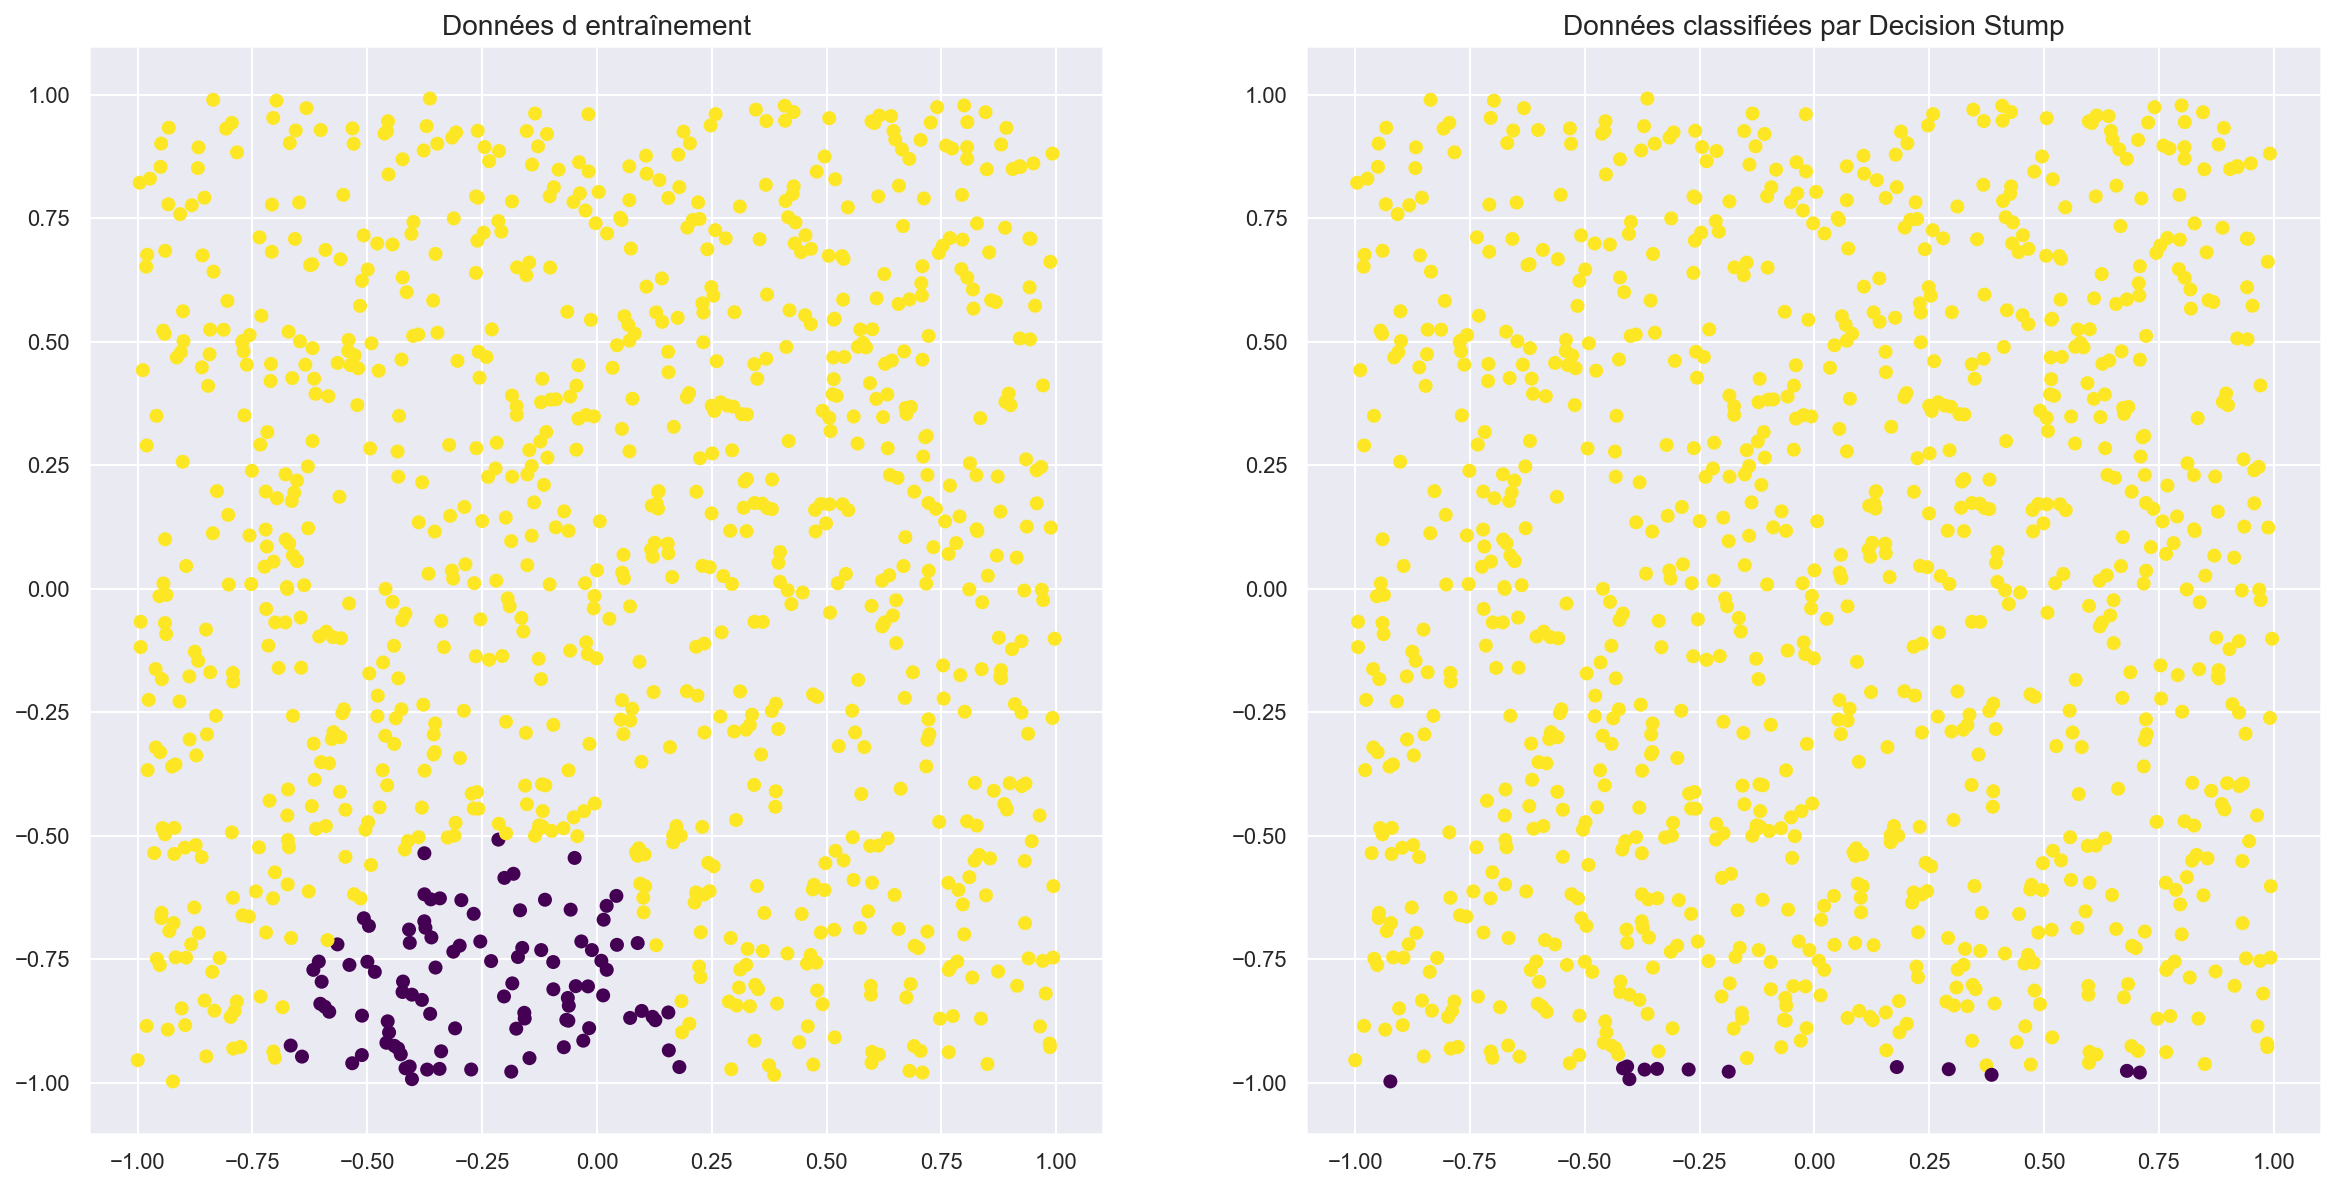

In [99]:
def plot_results( x, y, yweak, method):
    
    plt.figure(1)
    plt.rcParams["figure.figsize"] = [20,10]
    fig,axs=plt.subplots(1,2)
    axs[0].scatter(x[:,0],x[:,1],c=y[:,0],cmap=plt.cm.viridis,marker='o')
    axs[0].set_title('Données d entraînement',fontsize=14)
    axs[1].scatter(x[:,0],x[:,1],c=yweak[:,0],cmap=plt.cm.viridis,marker='o')
    axs[1].set_title('Données classifiées par '+method,fontsize=14)
    return fig, axs

plot_results( x, y, yweak, "Decision Stump")

In [100]:
(H,epsilon)=adaboost(x,y,100,ERM_Stump)

 [Elapsed Time: 0:00:01] |############################################| [100%] 


Ci-dessous, on affiche à gauche les données d'entraînement et à droite le résultat de la classification des mêmes données d'entraînement par le résultat d'AdaBoost

(<Figure size 1440x720 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x126144668>,
       dtype=object))

<Figure size 1440x720 with 0 Axes>

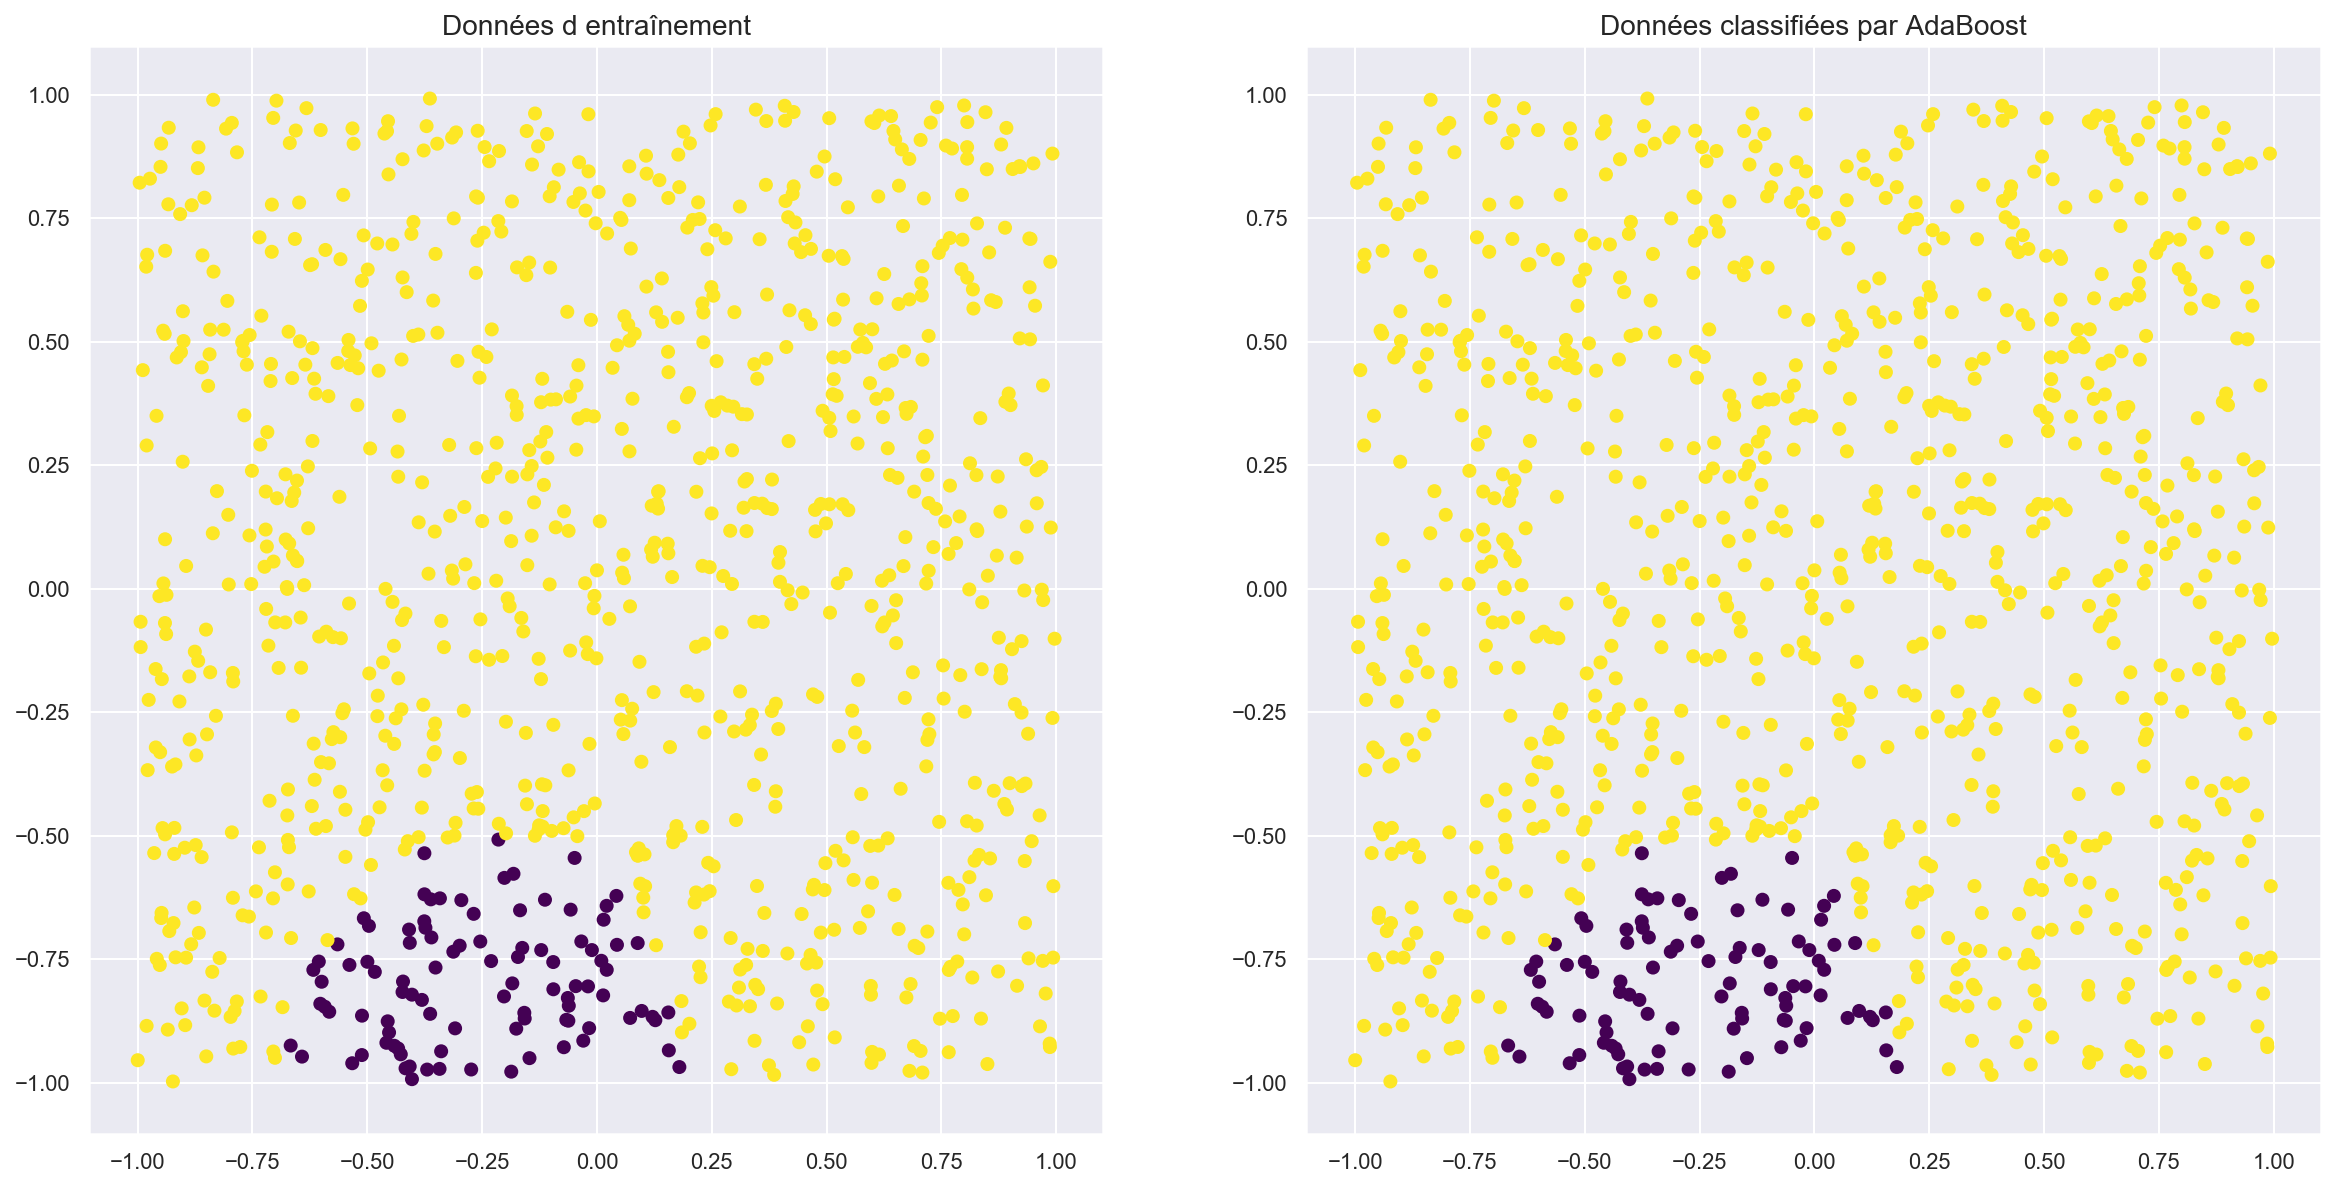

In [101]:
yresult=H(x)

plot_results(x, y, yresult, "AdaBoost")

In [44]:
a=100*(1-H.erreur(x,y))
print("Performance sur les données d'entraînement :",a[0],"%")

Performance sur les données d'entraînement : 99.9 %


Ci-dessous, on affiche à gauche les données de test et à droite le résultat de la classification des mêmes données de test par le résultat d'AdaBoost

(<Figure size 1440x720 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x119255a90>,
       dtype=object))

<Figure size 1440x720 with 0 Axes>

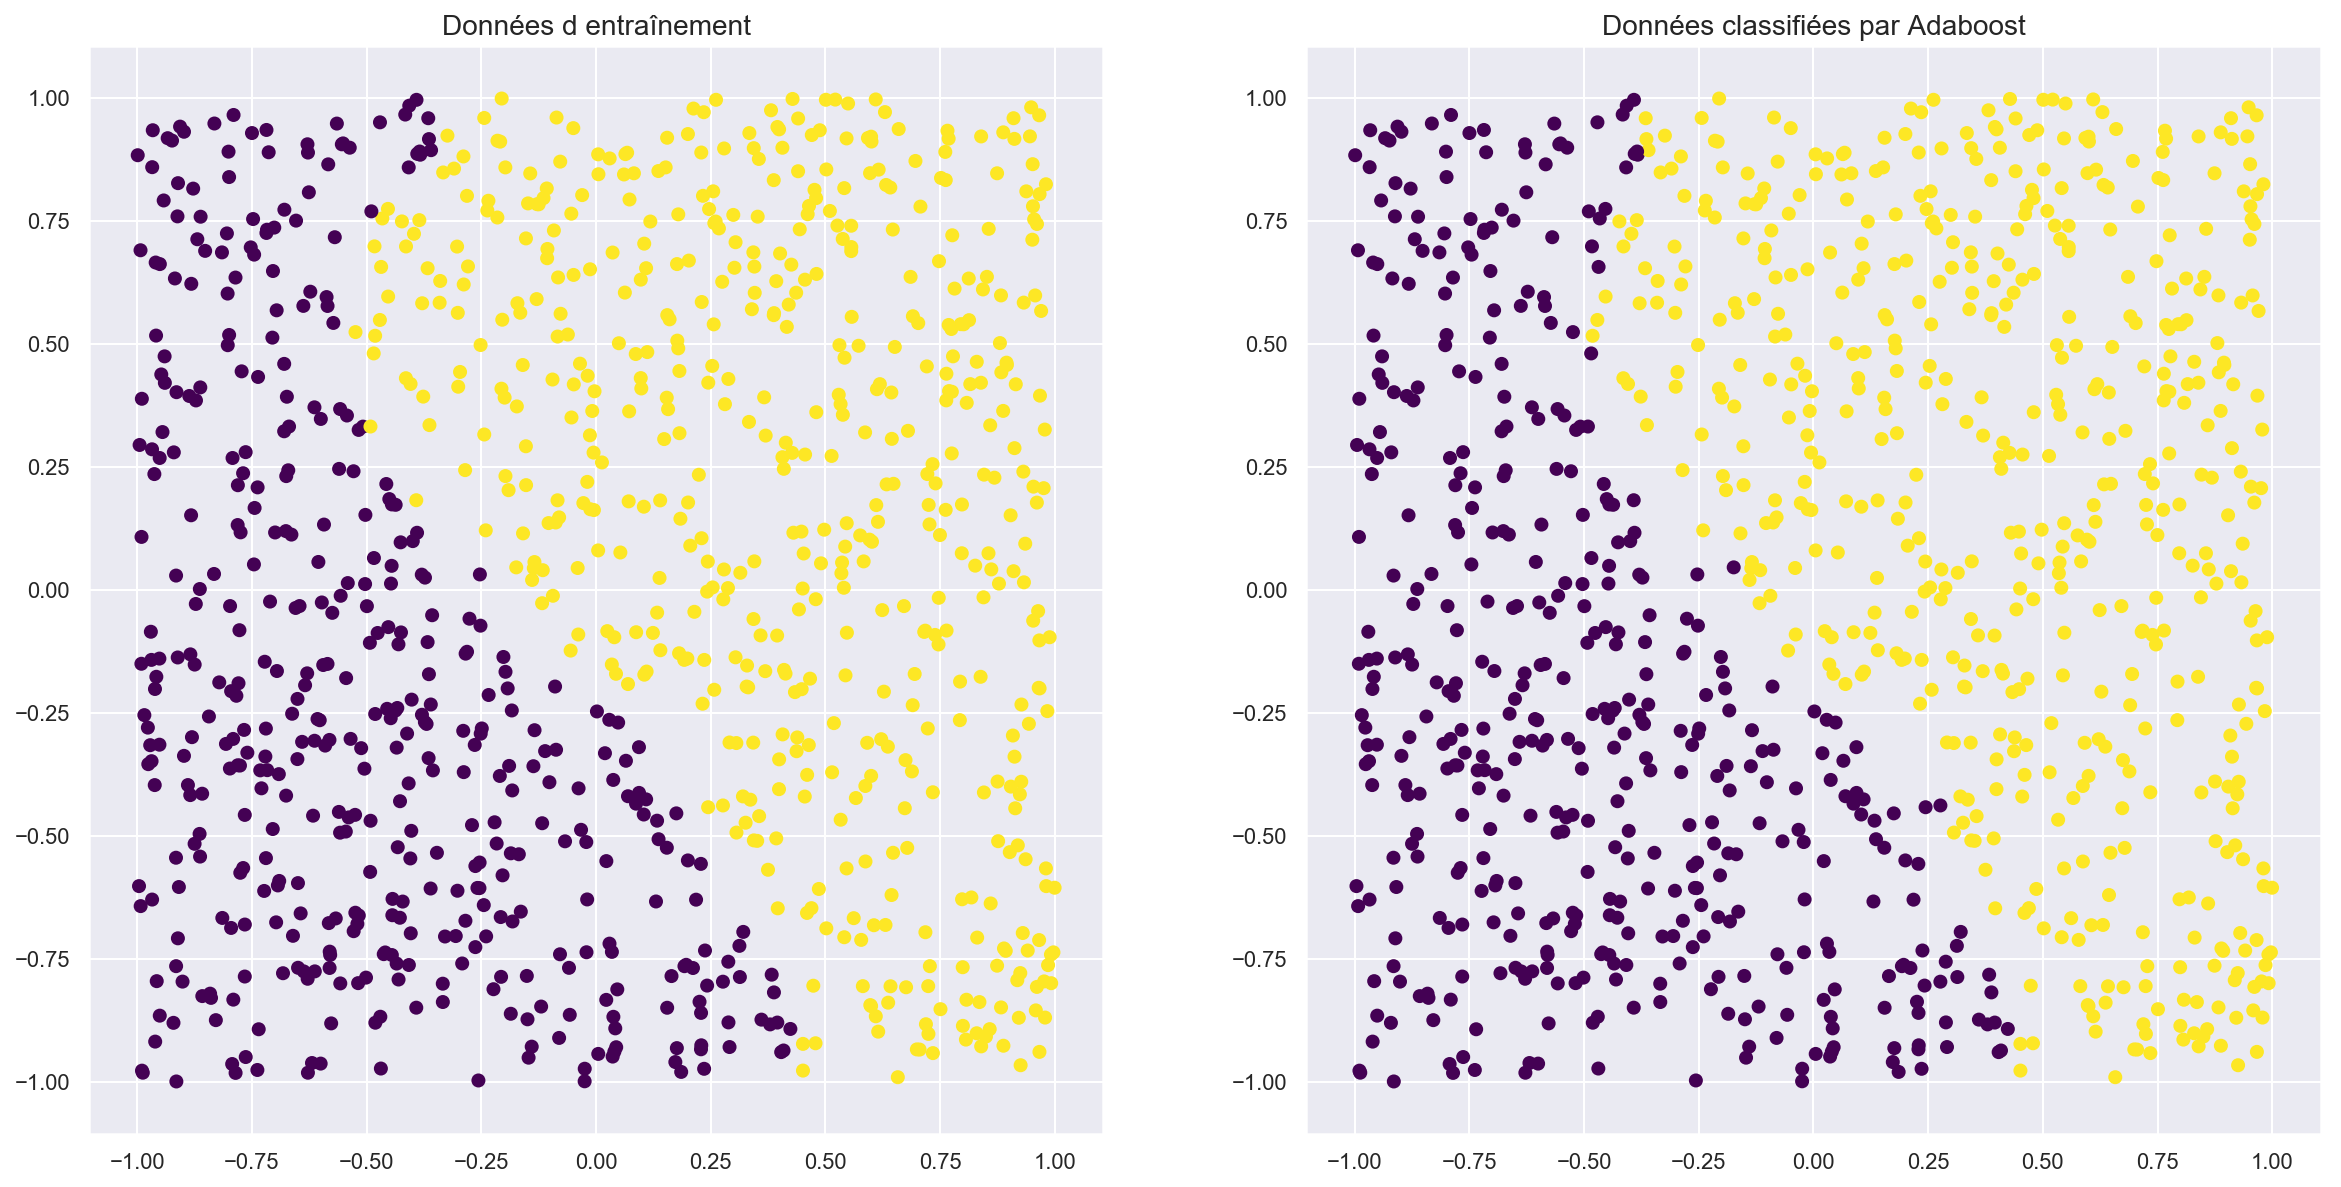

In [45]:
xtest, ytest = generate_data(m, d, seed=0)
with open("test2.txt","w") as f:
    np.savetxt(f, np.hstack((xtest,ytest)))
yresulttest  = H(xtest)
plot_results(xtest, ytest, yresulttest, "Adaboost")

In [46]:
a=100*(1-H.erreur(xtest,ytest))
print("Performance sur les données de test :",a[0],"%")

Performance sur les données de test : 98.6 %


Ci-dessous, on affiche l'erreur de l'algorithme AdaBoost (en pourcentages) au cours des itérations

Text(0, 0.5, 'Erreur en %')

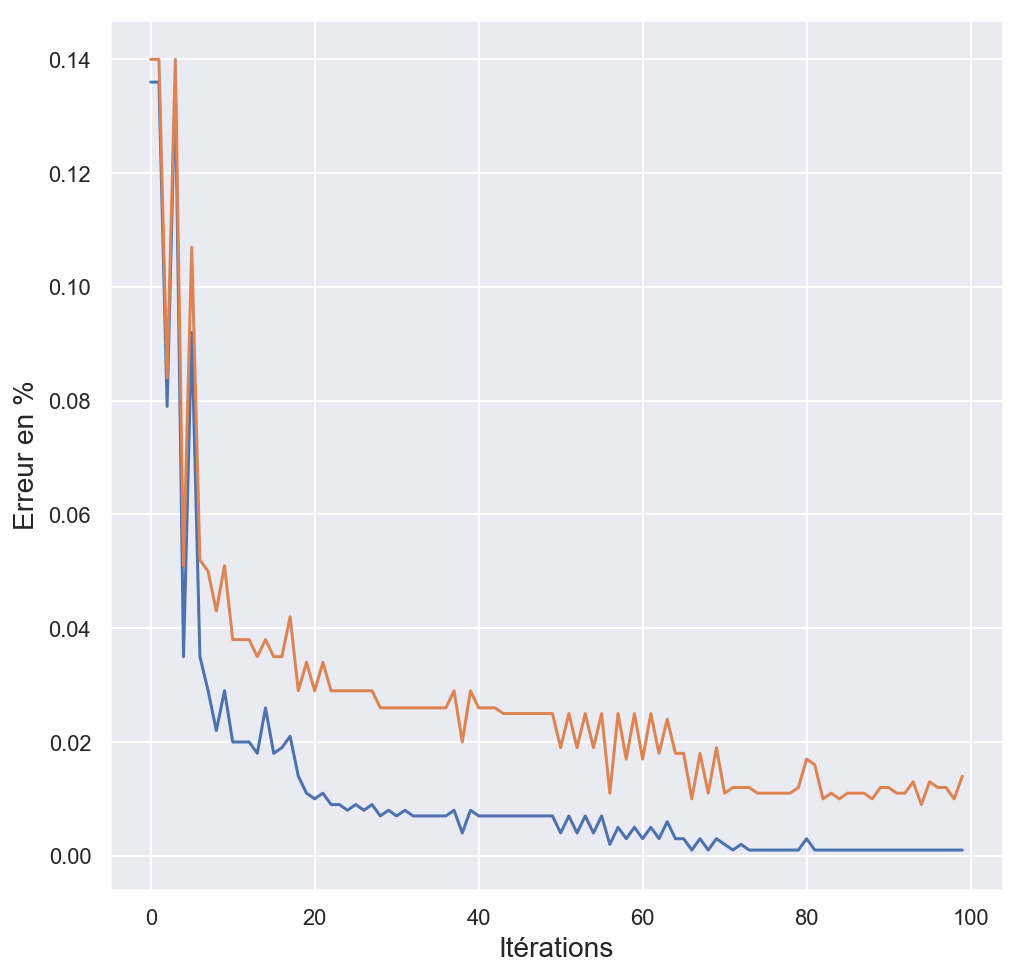

In [47]:
err=[]
err0=0
err_test=[]
err_test0=0
for i in range(int(len(H.stumps))):
    err0+=H.weights[i]*H.stumps[i](x)
    err.append(sum(np.sign(err0)!=y)/len(y))
    err_test0+=H.weights[i]*H.stumps[i](xtest)
    err_test.append(sum(np.sign(err_test0)!=ytest)/len(ytest))
fig,ax=plt.subplots(figsize=(8,8))
ax.plot(err)
ax.plot(err_test)
ax.set_xlabel('Itérations',fontsize=14)
ax.set_ylabel('Erreur en %',fontsize=14)

(0.136, 0.5)

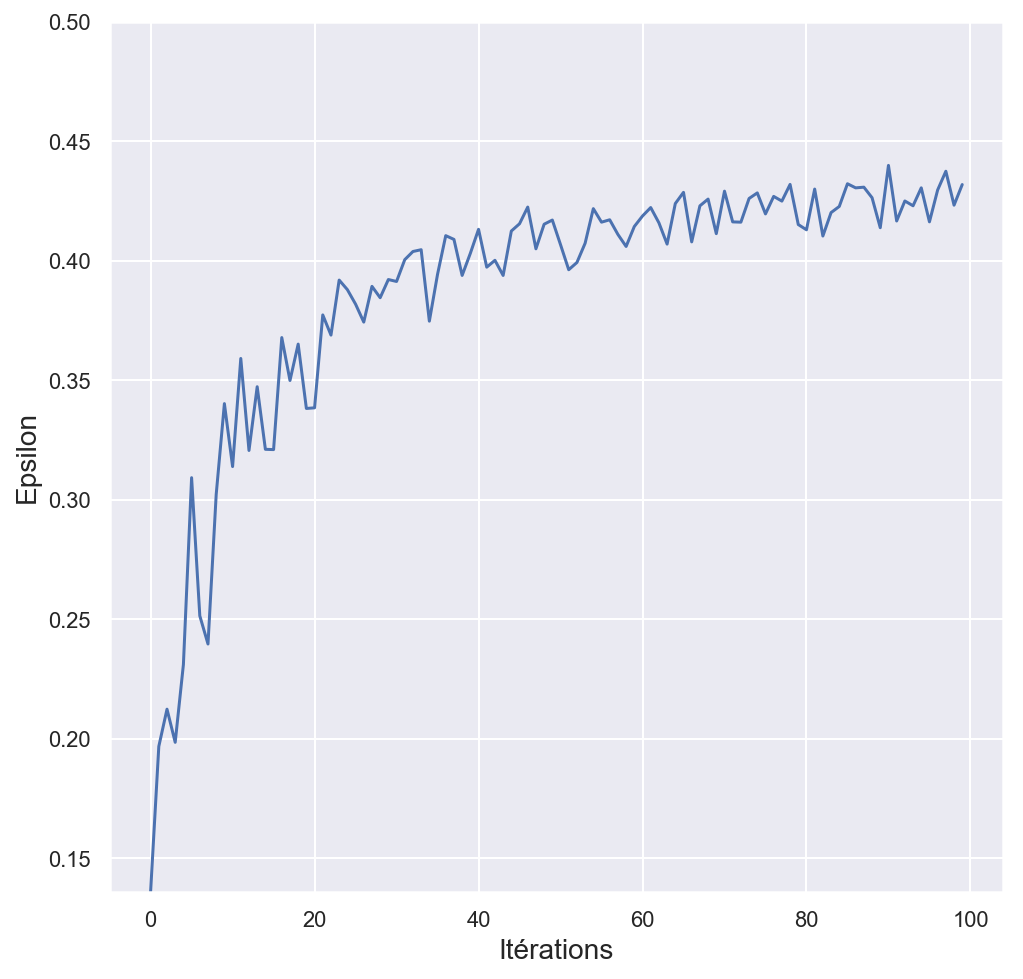

In [48]:
fig,ax=plt.subplots(figsize=(8,8))
ax.plot(epsilon)
ax.set_xlabel('Itérations',fontsize=14)
ax.set_ylabel('Epsilon',fontsize=14)
axes = plt.gca()
axes.set_ylim(np.min(epsilon), 0.5)

## Cas test 2

Deuxième série de données, issues du UCI machine learning repository : https://archive.ics.uci.edu/ml/datasets/banknote+authentication

Ce sont des données sur des billets de banque. Pour chaque billet, on a 5 données, dans l'ordre : Variance of Wavelet Transformed Image, Skewness of Wavelet Transformed image, Curtosis of Wavelet Transformed image, Entropy of image, Class (Class contains two values 0 representing genuine note and 1 representing fake note)

In [49]:
fichier = open("data_banknote_authentication.txt", "r")

In [50]:
databrute=fichier.read().splitlines()

In [51]:
print("Nombre de données : ", np.shape(databrute)[0])

Nombre de données :  1372


In [52]:
taille=np.shape(databrute)[0]
data=np.zeros((taille,5))
for i in range(taille):
    data[i,:]=databrute[i].split(',')

In [53]:
count=0
for i in range(taille):
    if data[i,4]==0:
        count+=1
print("Pourcentage de vrais billets :",count/taille*100,"%")

Pourcentage de vrais billets : 55.539358600583085 %


In [54]:
taille_training=int(taille*0.8)
taille_test=taille-taille_training
indice=np.random.permutation(taille)
training=data[indice[0:taille_training]]
test=data[indice[taille_training:taille]]
x=training[:,0:4]
y=2*np.transpose([training[:,4]])-1
xtest=test[:,0:4]
ytest=2*np.transpose([test[:,4]])-1
d=4
m=taille_training

In [55]:
(H,epsilon)=adaboost(x,y,50,ERM_Stump)

 [Elapsed Time: 0:00:01] |############################################| [100%] 


In [56]:
yresult=H(x)
yresulttest=H(xtest)

In [57]:
a=100*(1-H.erreur(x,y))
print("Performance sur les données d'entraînement :",a[0],"%")

Performance sur les données d'entraînement : 100.0 %


In [58]:
a=100*(1-H.erreur(xtest,ytest))
print("Performance sur les données de test :",a[0],"%")

Performance sur les données de test : 99.63636363636364 %


Ci-dessous, on affiche l'erreur de l'algorithme AdaBoost (en pourcentages) au cours des itérations

Text(0, 0.5, 'Erreur en %')

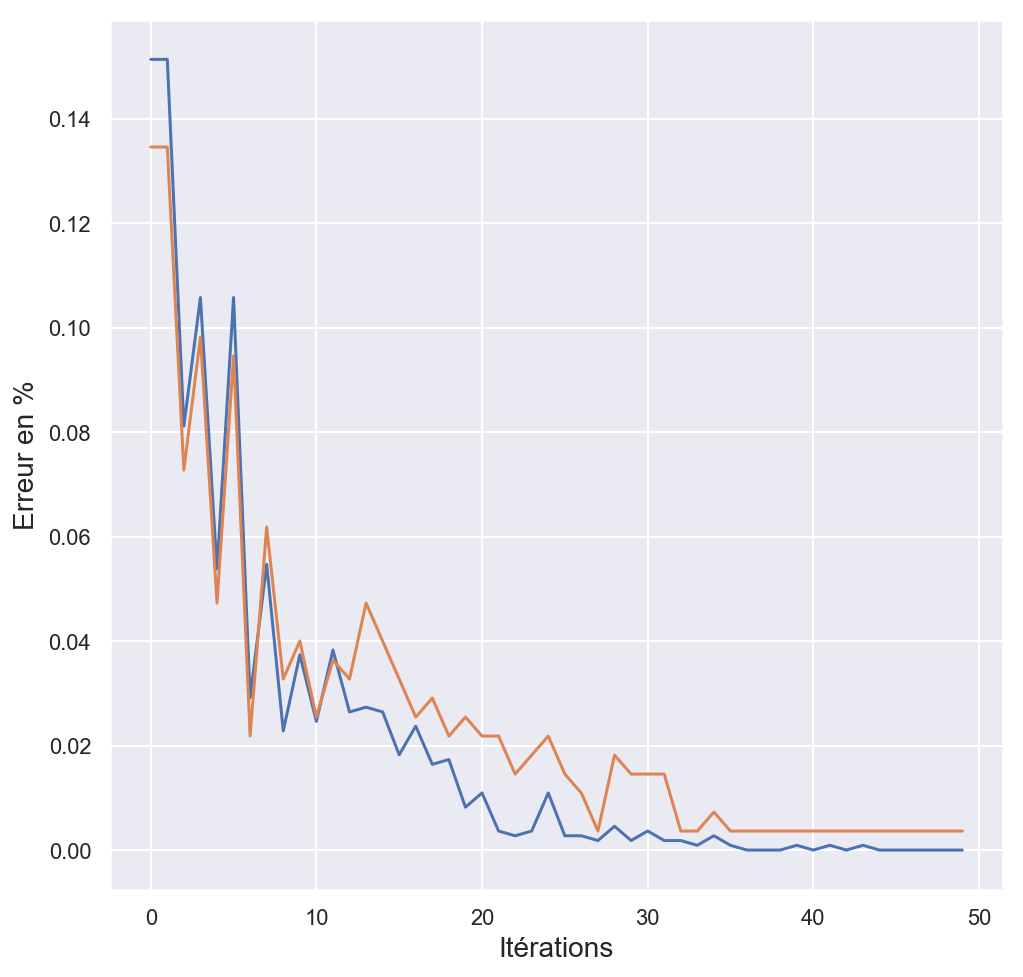

In [59]:
err=[]
err0=0
err_test=[]
err_test0=0
for i in range(int(len(H.stumps))):
    err0+=H.weights[i]*H.stumps[i](x)
    err.append(sum(np.sign(err0)!=y)/len(y))
    err_test0+=H.weights[i]*H.stumps[i](xtest)
    err_test.append(sum(np.sign(err_test0)!=ytest)/len(ytest))
fig,ax=plt.subplots(figsize=(8,8))
ax.plot(err)
ax.plot(err_test)
ax.set_xlabel('Itérations',fontsize=14)
ax.set_ylabel('Erreur en %',fontsize=14)

(0.1513217866909754, 0.5)

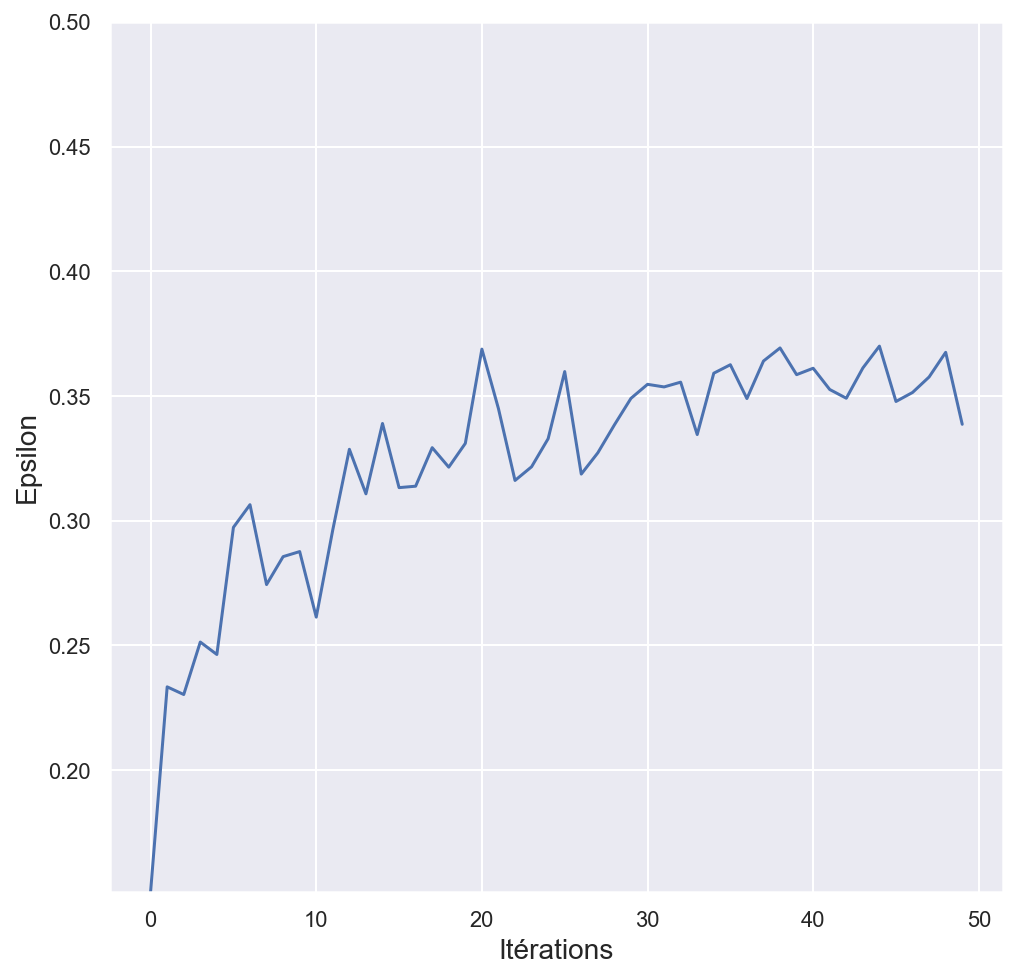

In [60]:
fig,ax=plt.subplots(figsize=(8,8))
ax.plot(epsilon)
ax.set_xlabel('Itérations',fontsize=14)
ax.set_ylabel('Epsilon',fontsize=14)
axes = plt.gca()
axes.set_ylim(np.min(epsilon), 0.5)

In [61]:
print("borne d'erreur théorique",np.exp(-2*sum((1/2-np.array(epsilon))**2))*100,"%")

borne d'erreur théorique 3.735840400907034 %


(<Figure size 1440x720 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1245f5780>,
       dtype=object))

<Figure size 1440x720 with 0 Axes>

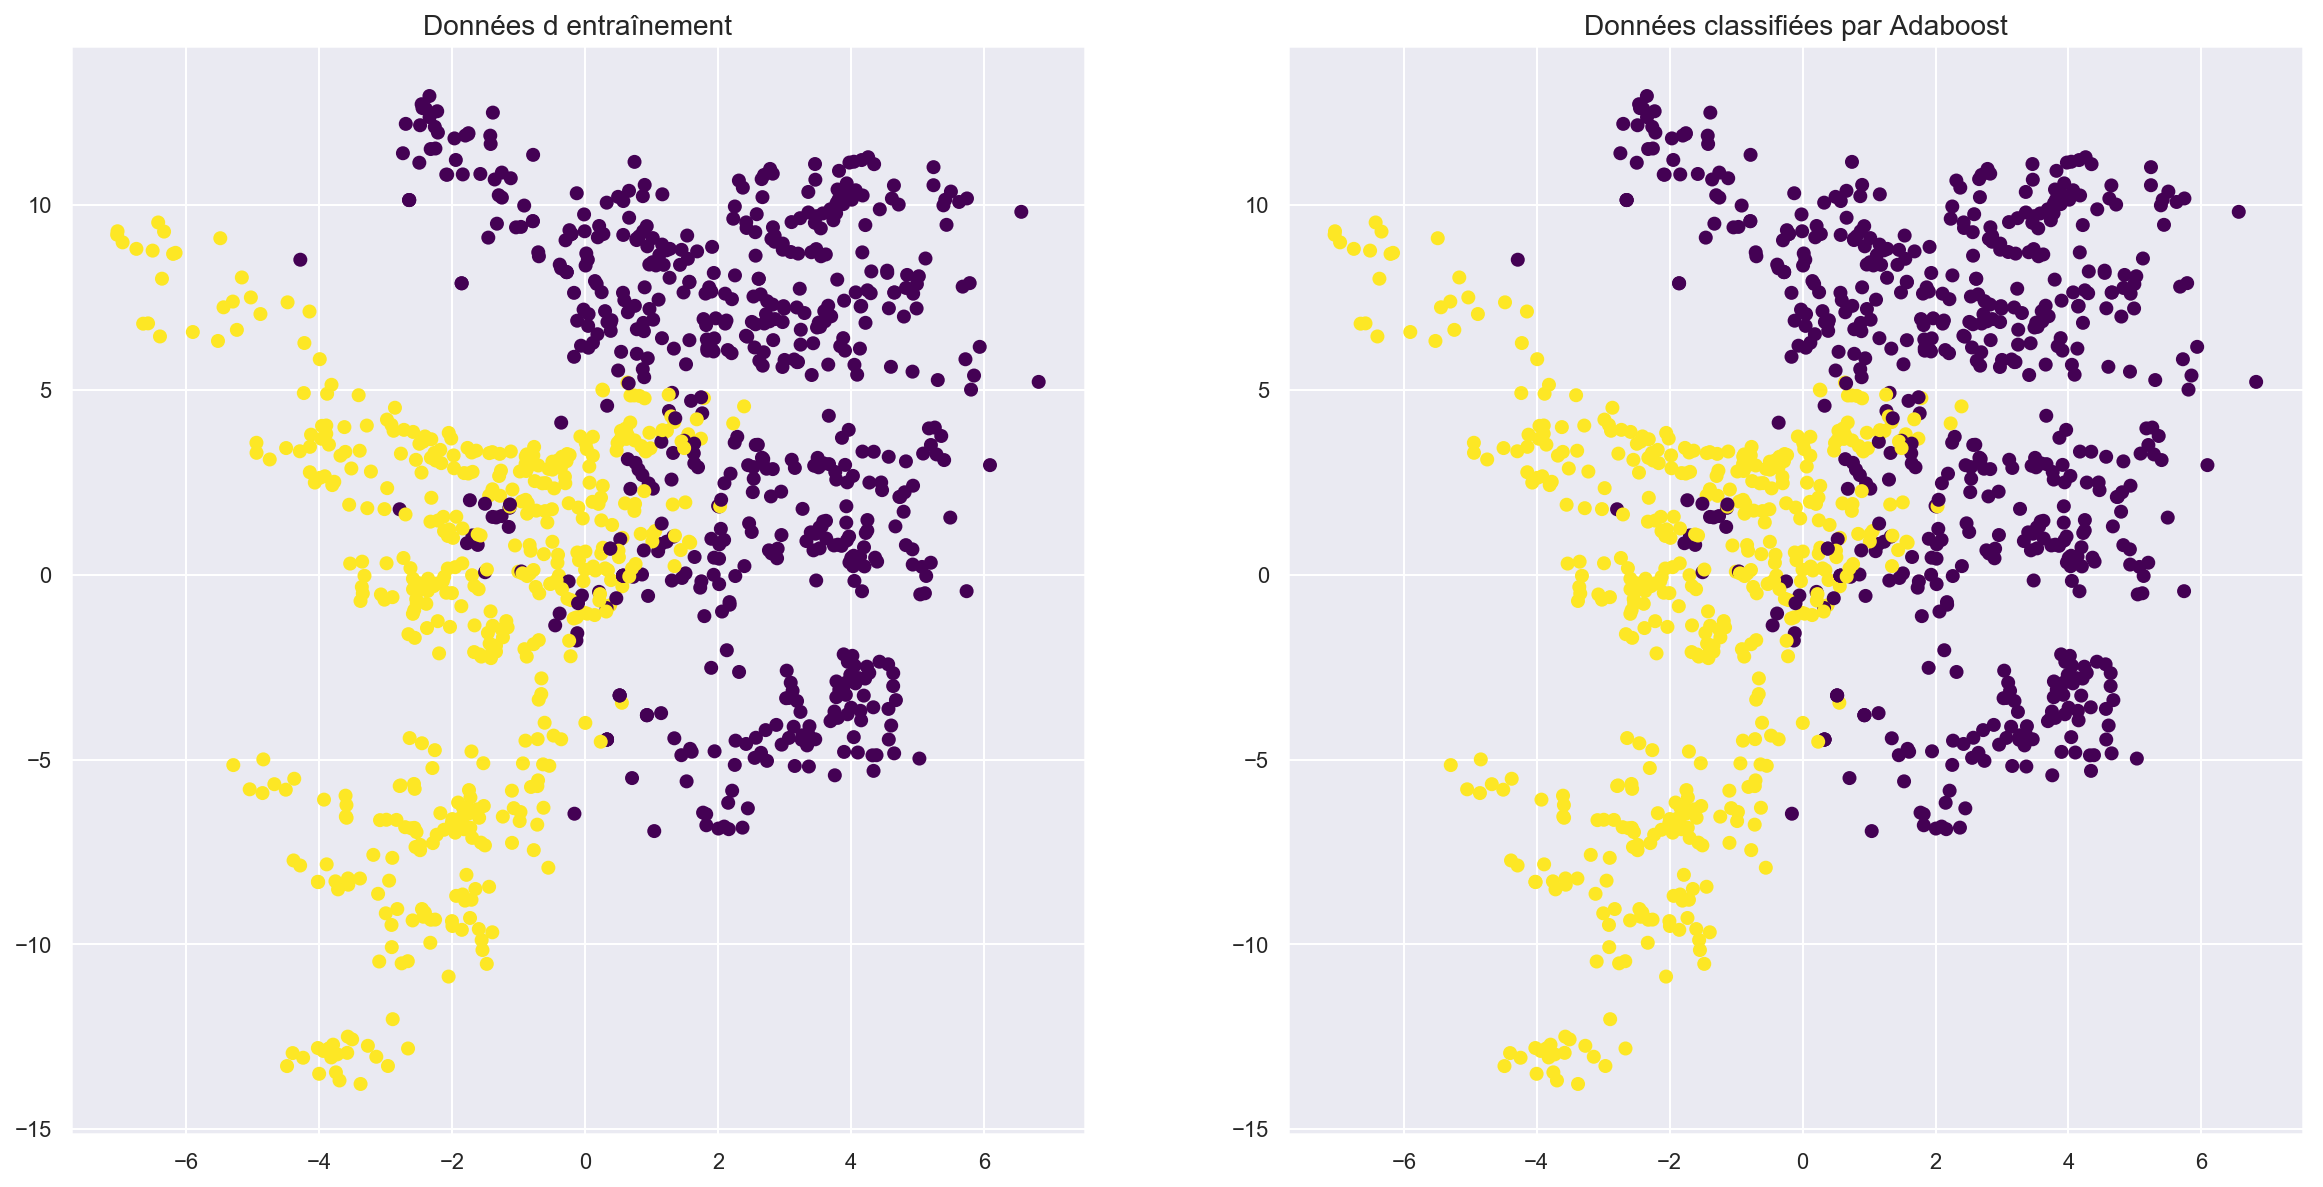

In [64]:
plot_results(x, y, yresult, "Adaboost")

(<Figure size 1440x720 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1245f5cc0>,
       dtype=object))

<Figure size 1440x720 with 0 Axes>

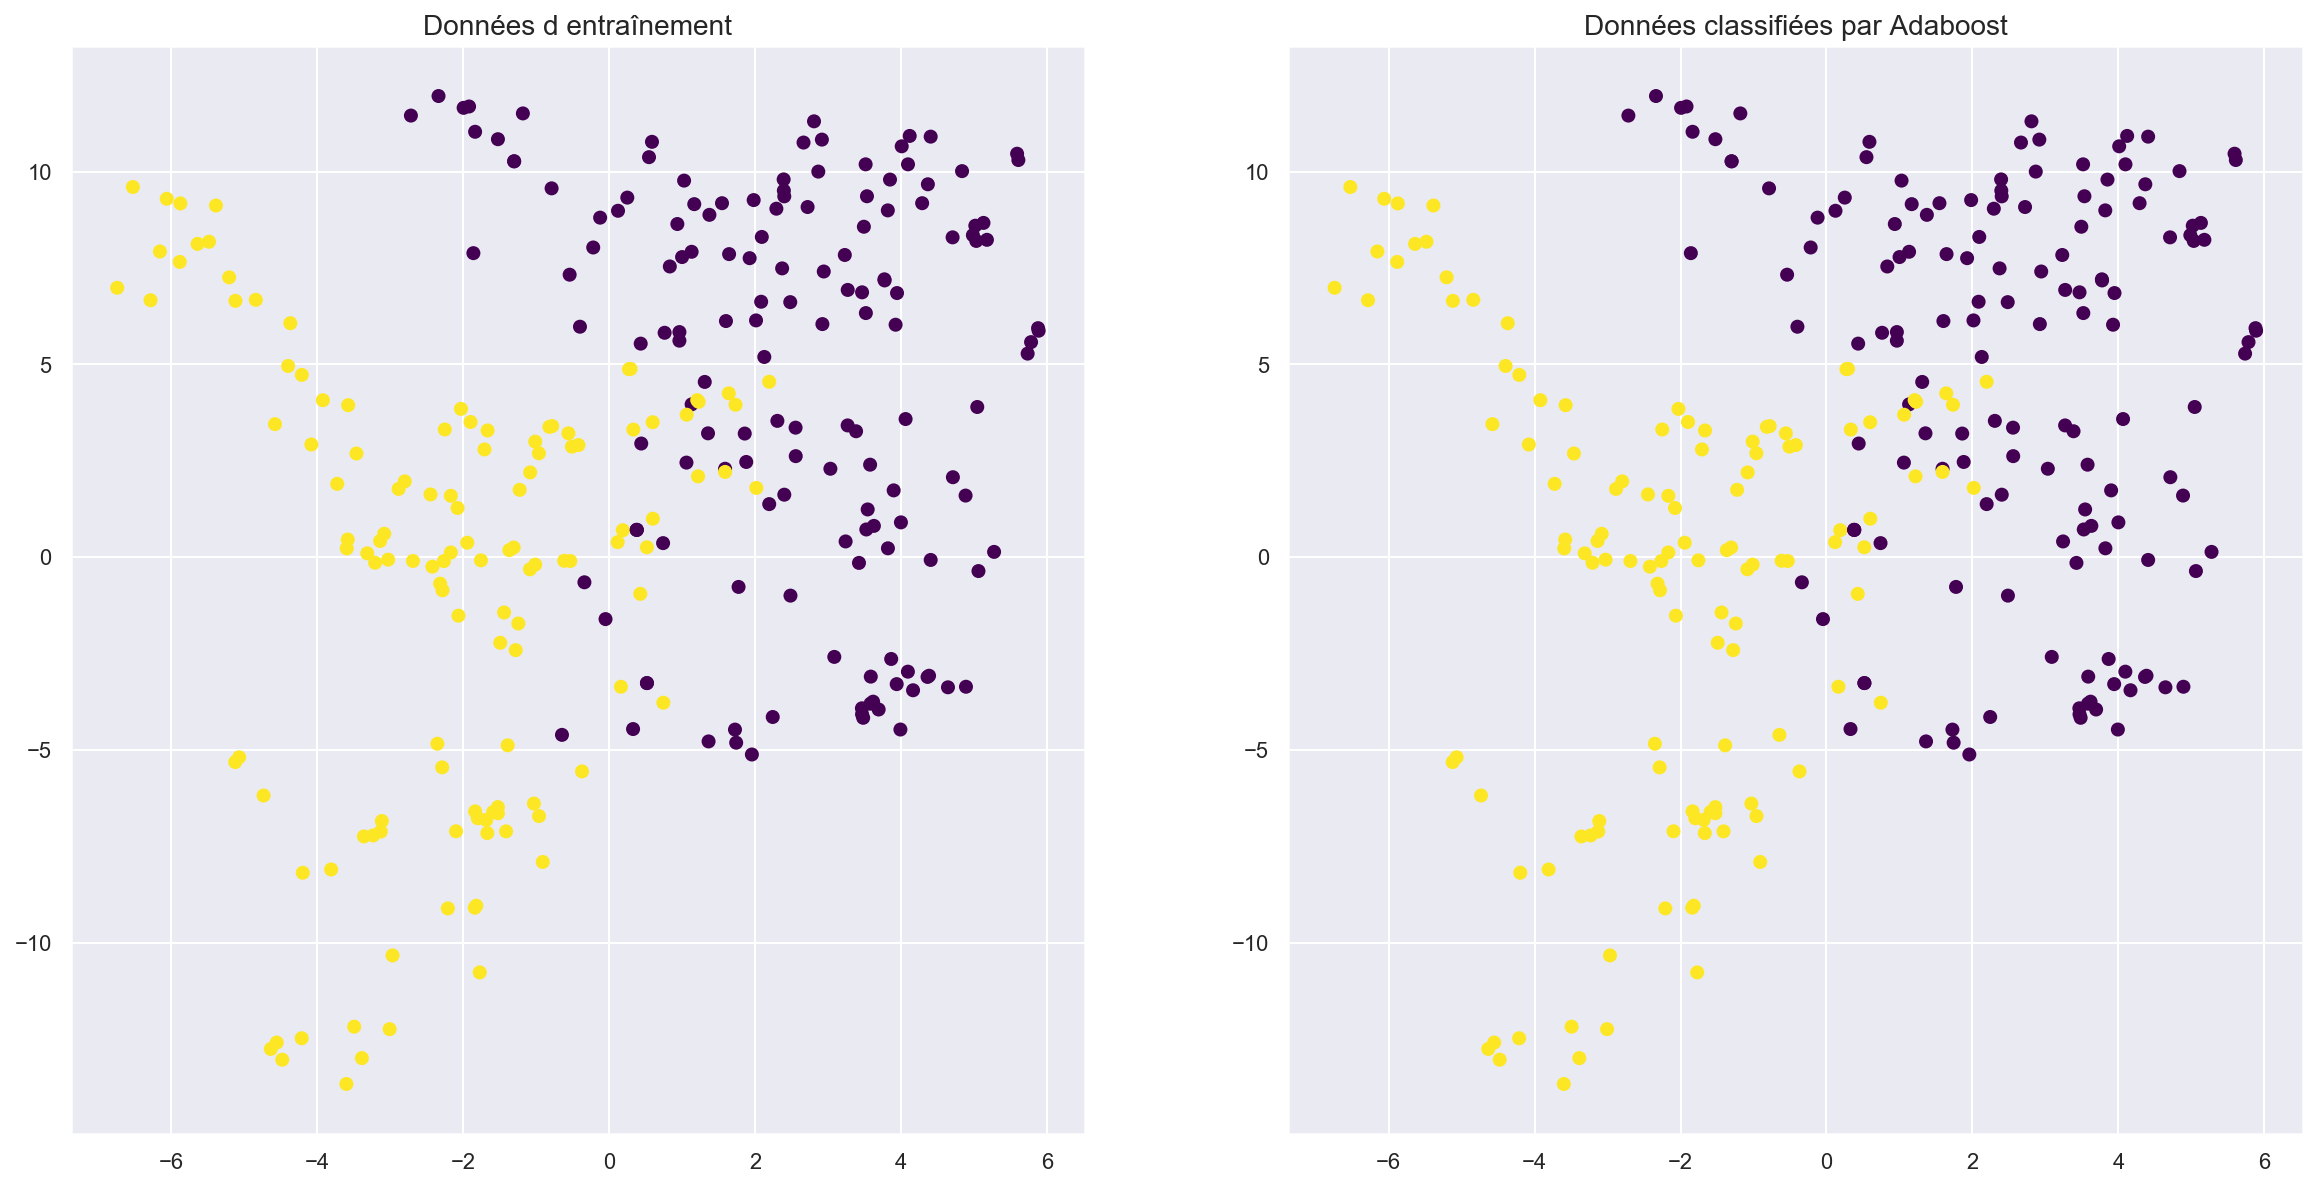

In [65]:
plot_results(xtest, ytest, yresulttest, "Adaboost")

## Cas test 3

Troisième série de données, issues du UCI machine learning repository : https://archive.ics.uci.edu/ml/datasets/EEG+Eye+State

Chaque ligne a 15 attributs. Les 14 premiers sont des mesures d'ElectroEncéphaloGrammes et le 15ème est un indicateur disant si le patient avait les yeux ouverts ou fermés.

In [66]:
fichier = open("EEG_Eye_State.txt", "r")

In [67]:
databrute=fichier.read().splitlines()

In [68]:
print("Nombre de données : ", np.shape(databrute)[0])

Nombre de données :  14980


In [69]:
taille=np.shape(databrute)[0]
data=np.zeros((taille,15))
for i in range(taille):
    data[i,:]=databrute[i].split(',')

In [70]:
count=0
for i in range(taille):
    if data[i,14]==0:
        count+=1
print("Pourcentage de classe 0 :",count/taille*100,"%")

Pourcentage de classe 0 : 55.12016021361815 %


In [71]:
taille_training=int(taille/3)
taille_validation=int(taille/3)
taille_test=taille-taille_training-taille_validation
indice=np.random.permutation(taille)
training=data[indice[0:taille_training]]
validation=data[indice[taille_training:taille_training+taille_validation]]
test=data[indice[taille_training+taille_validation:taille]]
x=training[:,0:14]
y=2*np.transpose([training[:,14]])-1
xvalidation=validation[:,0:14]
yvalidation=2*np.transpose([validation[:,14]])-1
xtest=test[:,0:14]
ytest=2*np.transpose([test[:,14]])-1
d=14
m=taille_training

In [72]:
(H,epsilon)=adaboost(x,y,2000,ERM_Stump)

 [Elapsed Time: 0:14:38] |############################################| [100%] 


In [73]:
yresult=H(x)
yresulttest=H(xtest)

In [74]:
a=sum(yresult==y)/m*100
print("Performance sur les données d'entraînement :",a[0],"%")

Performance sur les données d'entraînement : 80.97336270779091 %


In [75]:
a=sum(yresulttest==ytest)/taille_test*100
print("Performance sur les données de test :",a[0],"%")

Performance sur les données de test : 75.93111734080897 %


Text(0, 0.5, 'Erreur en %')

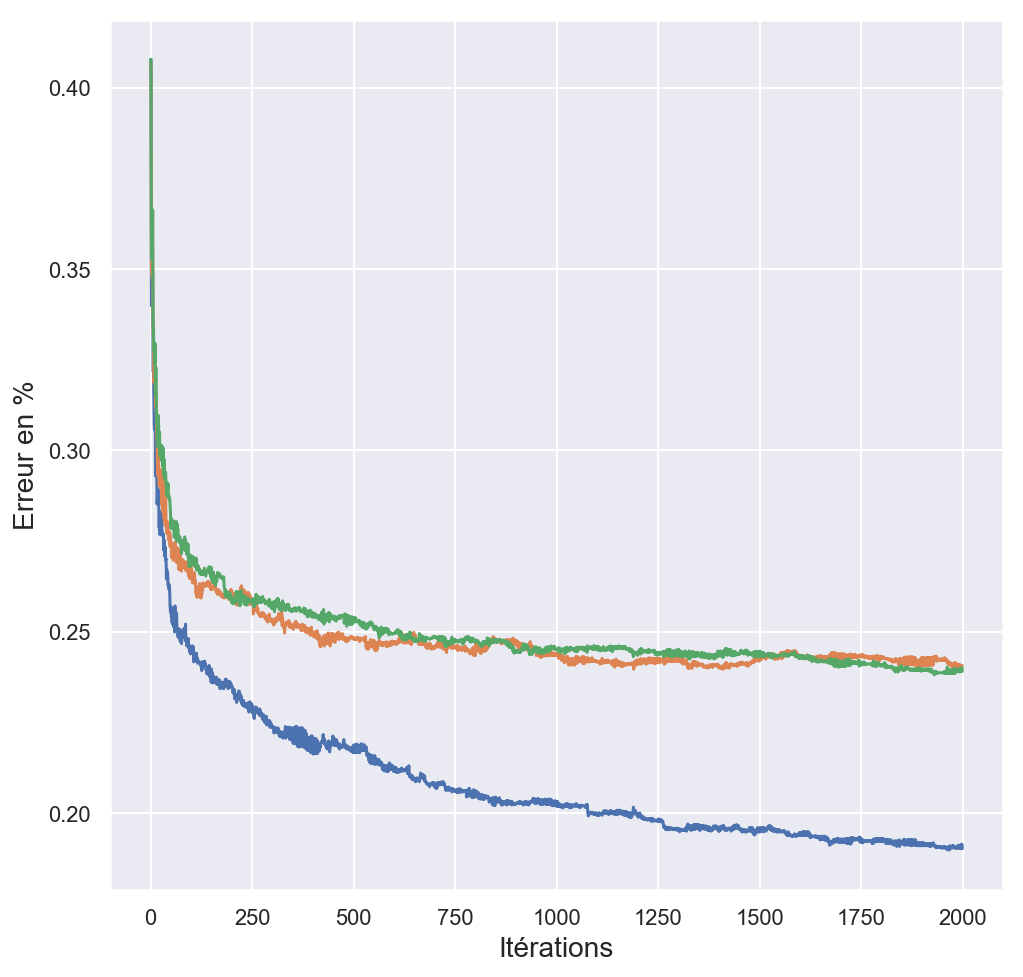

In [76]:
err=[]
err0=0
err_validation0=0
err_validation=[]
err_test=[]
err_test0=0
for i in range(int(len(H.stumps))):
    err0+=H.weights[i]*H.stumps[i](x)
    err.append(sum(np.sign(err0)!=y)/len(y))
    err_test0+=H.weights[i]*H.stumps[i](xtest)
    err_test.append(sum(np.sign(err_test0)!=ytest)/len(ytest))
    err_validation0+=H.weights[i]*H.stumps[i](xvalidation)
    err_validation.append(sum(np.sign(err_validation0)!=yvalidation)/len(yvalidation))
fig,ax=plt.subplots(figsize=(8,8))
ax.plot(err)
ax.plot(err_test)
ax.plot(err_validation)
ax.set_xlabel('Itérations',fontsize=14)
ax.set_ylabel('Erreur en %',fontsize=14)

(0.40757059883837377, 0.5)

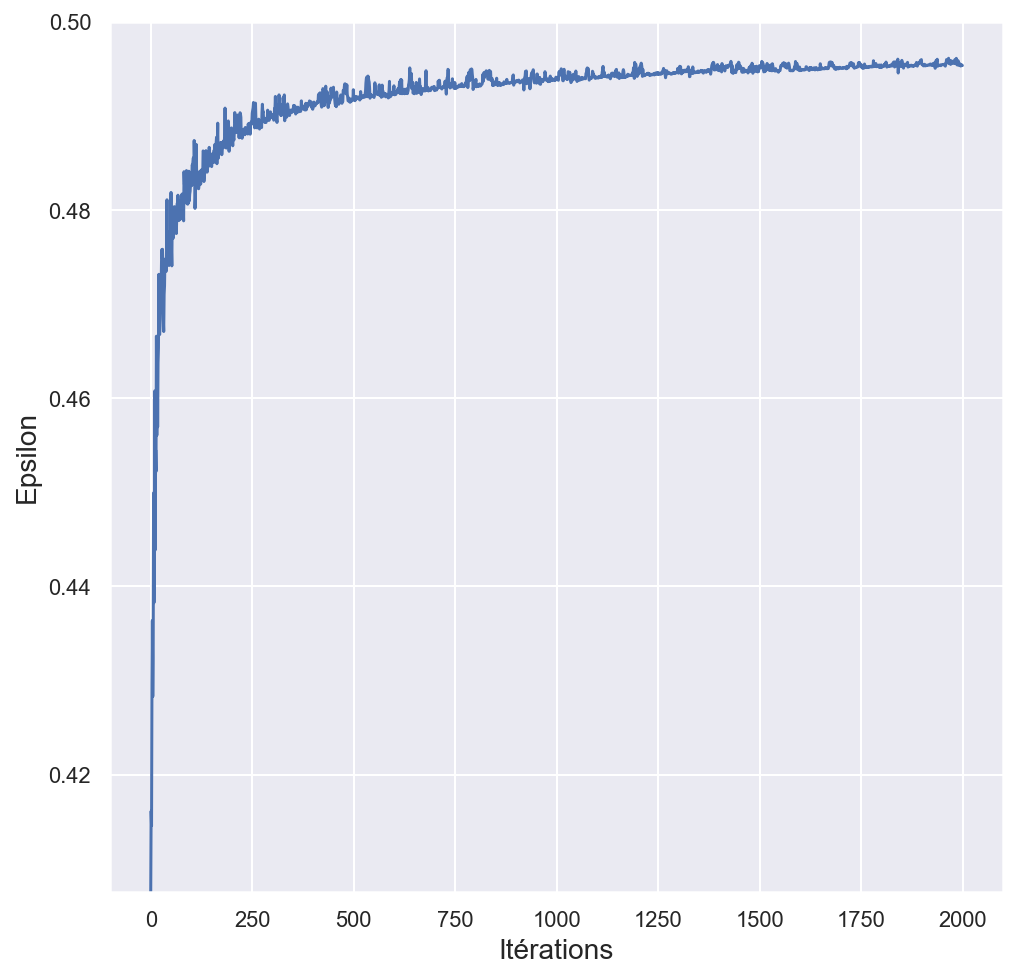

In [77]:
fig,ax=plt.subplots(figsize=(8,8))
ax.plot(epsilon)
ax.set_xlabel('Itérations',fontsize=14)
ax.set_ylabel('Epsilon',fontsize=14)
axes = plt.gca()
axes.set_ylim(np.min(epsilon), 0.5)

In [78]:
print("borne d'erreur théorique",np.exp(-2*sum((1/2-np.array(epsilon))**2))*100,"%")

borne d'erreur théorique 66.19217394225532 %


In [79]:
i=np.argmin(err_validation)
print(i)
print(err_test[i])
print(min(err_validation))

1930
[0.24209051]
[0.23813339]
